In [1]:
import core.deconV as dV
from core.base import NSM, MSEM
import core.plot as pl

import glob, tqdm, time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm

from scipy.optimize import curve_fit

Global seed set to 0


In [2]:
dV.params = {
    "jupyter": True,
    "tqdm": True,
    "cell_type_key": "cellType",
    "layer": "ncounts",
    "index_col": 0,
    # "selected_ct": ["alpha", "delta", "gamma", "beta"],
    "selected_ct": ["0", "1", "2"],
    "model_type": "prob",
    "ignore_others": True,
    "n_top_genes": -1,
    "plot_pseudo_bulk": False,
    "lr": 0.01,
    "epochs": 5000,
    "fig_fmt": "png",
    # "indir": "../../data/xin/",
    "indir": "../../data/GSE136148/",
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

In [3]:
sadata = dV.read_data(os.path.join(dV.params["indir"], "sc.tsv"))
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [4]:
print("Reading bulk data...")
badata = dV.read_data(os.path.join(dV.params["indir"], "bulk.tsv"), is_bulk=True)
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 1, genes: 58387


/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
print("Reading pheno data...")
pheno_df = pd.read_csv(os.path.join(dV.params["indir"], "pdata.tsv"), sep="\t", index_col=dV.params["index_col"])
pheno_df.index.name = None

sadata.obs = pd.concat([sadata.obs, pheno_df], axis=1)
assert dV.params["cell_type_key"] in sadata.obs.columns, f"{dV.params['cell_type_key']} not in obs columns"
sadata.obs[dV.params["cell_type_key"]] = sadata.obs[dV.params["cell_type_key"]].astype(str)
sadata.obs

Reading pheno data...


,cellType
AAACCTGAGAATAGGG-1,0
AAACCTGAGGGTATCG-1,0
AAACCTGCATTCTTAC-1,0
AAACCTGGTCCGCTGA-1,0
AAACCTGTCCAGTATG-1,0
...,...
TTTGTCAAGTACGTAA-1,0
TTTGTCACACCAGGCT-1,0
TTTGTCACATGCATGT-1,0
TTTGTCAGTAGGCATG-1,0


In [6]:
print("Preprocessing data...")
sadata, badata = dV.preprocess(sadata, badata)
print("After preprocessing:")
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

assert sadata.shape[1] == badata.shape[1], "scRNA-seq and bulk RNA-seq data have different number of genes"

Preprocessing data...
After preprocessing:
scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


In [7]:
cell_types = list(sadata.obs[dV.params['cell_type_key']].unique())
cell_types

['0', '2', '1']

In [8]:
decon = dV.DeconV(sadata, badata, cell_types, dV.params, use_sub_types=False)

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
sc.tl.leiden(decon.sadata, resolution=0.05, key_added="leiden")
decon.label_key = "leiden"
decon.n_labels = len(decon.sadata.obs["leiden"].cat.categories)
decon.cell_types = list(decon.sadata.obs["leiden"].unique())
dV.params["cell_type_key"] = "leiden"

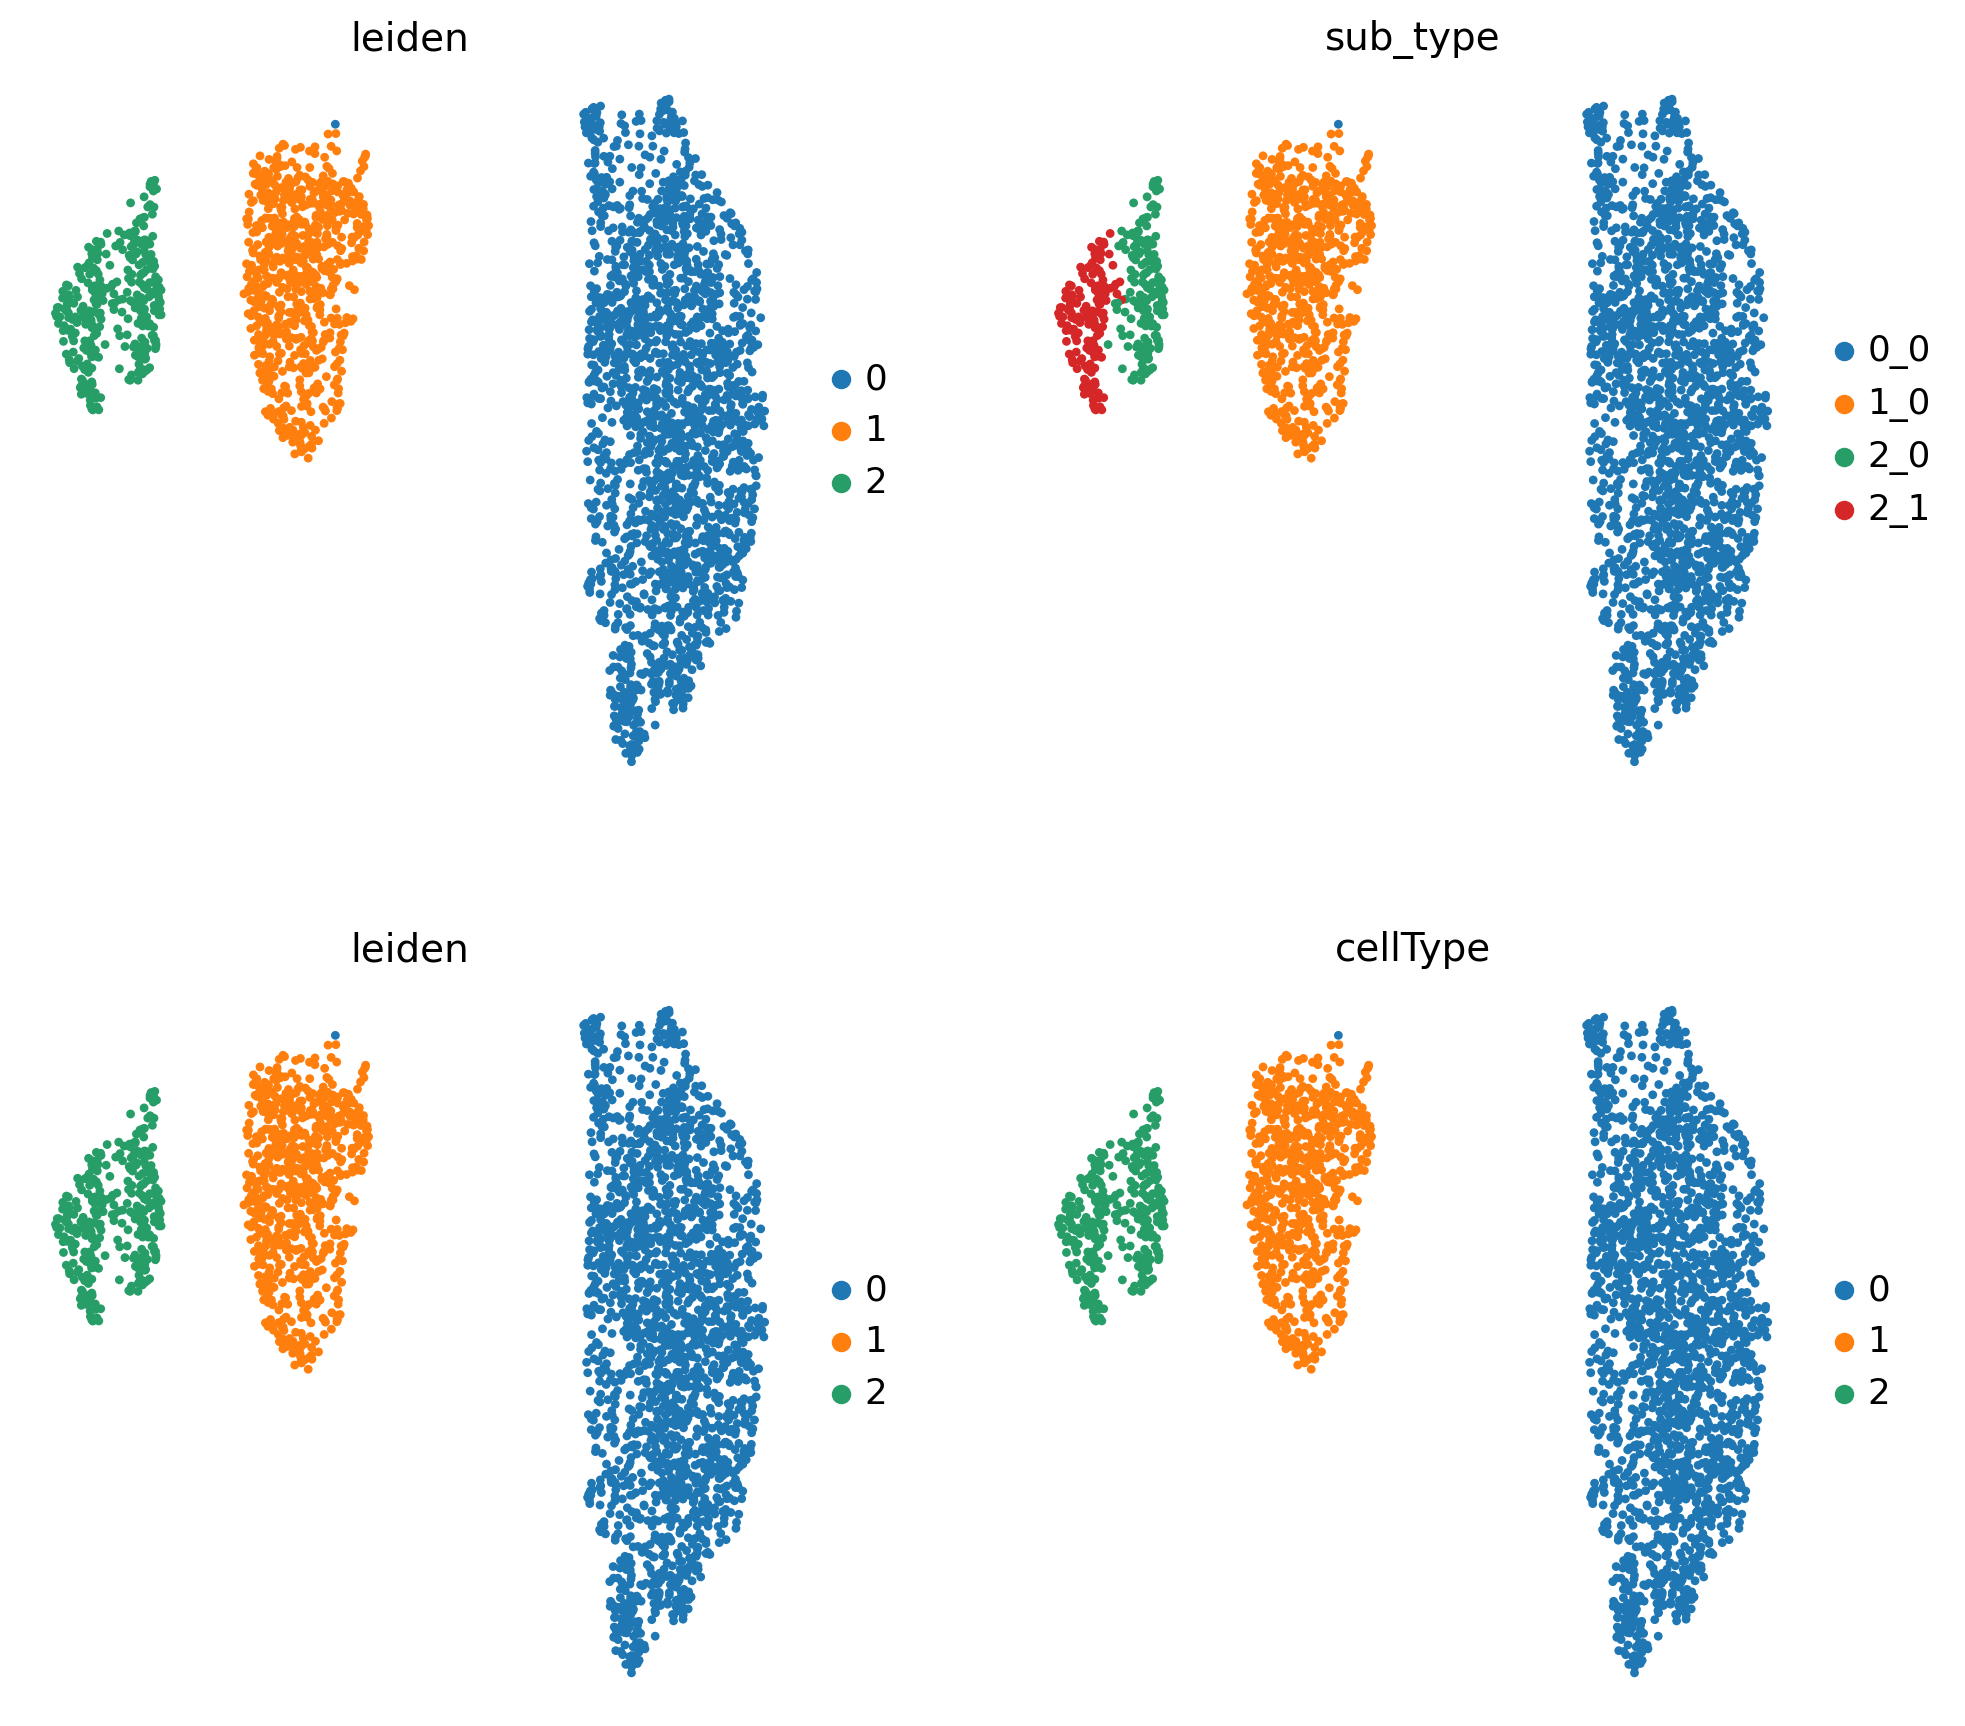

In [10]:
decon.sub_cluster(leiden_res=0.1)
pl.umap_plot(decon, show=True, keys=[dV.params['cell_type_key'], "sub_type", "leiden", "cellType"])

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 2993 points with dimension 50
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 99.697, Violated triplets: 0.0606
Iteration:  200, Loss: 92.995, Violated triplets: 0.0565
Iteration:  300, Loss: 89.297, Violated triplets: 0.0542
Iteration:  400, Loss: 86.851, Violated triplets: 0.0528
Elapsed time: 0:00:01.281483


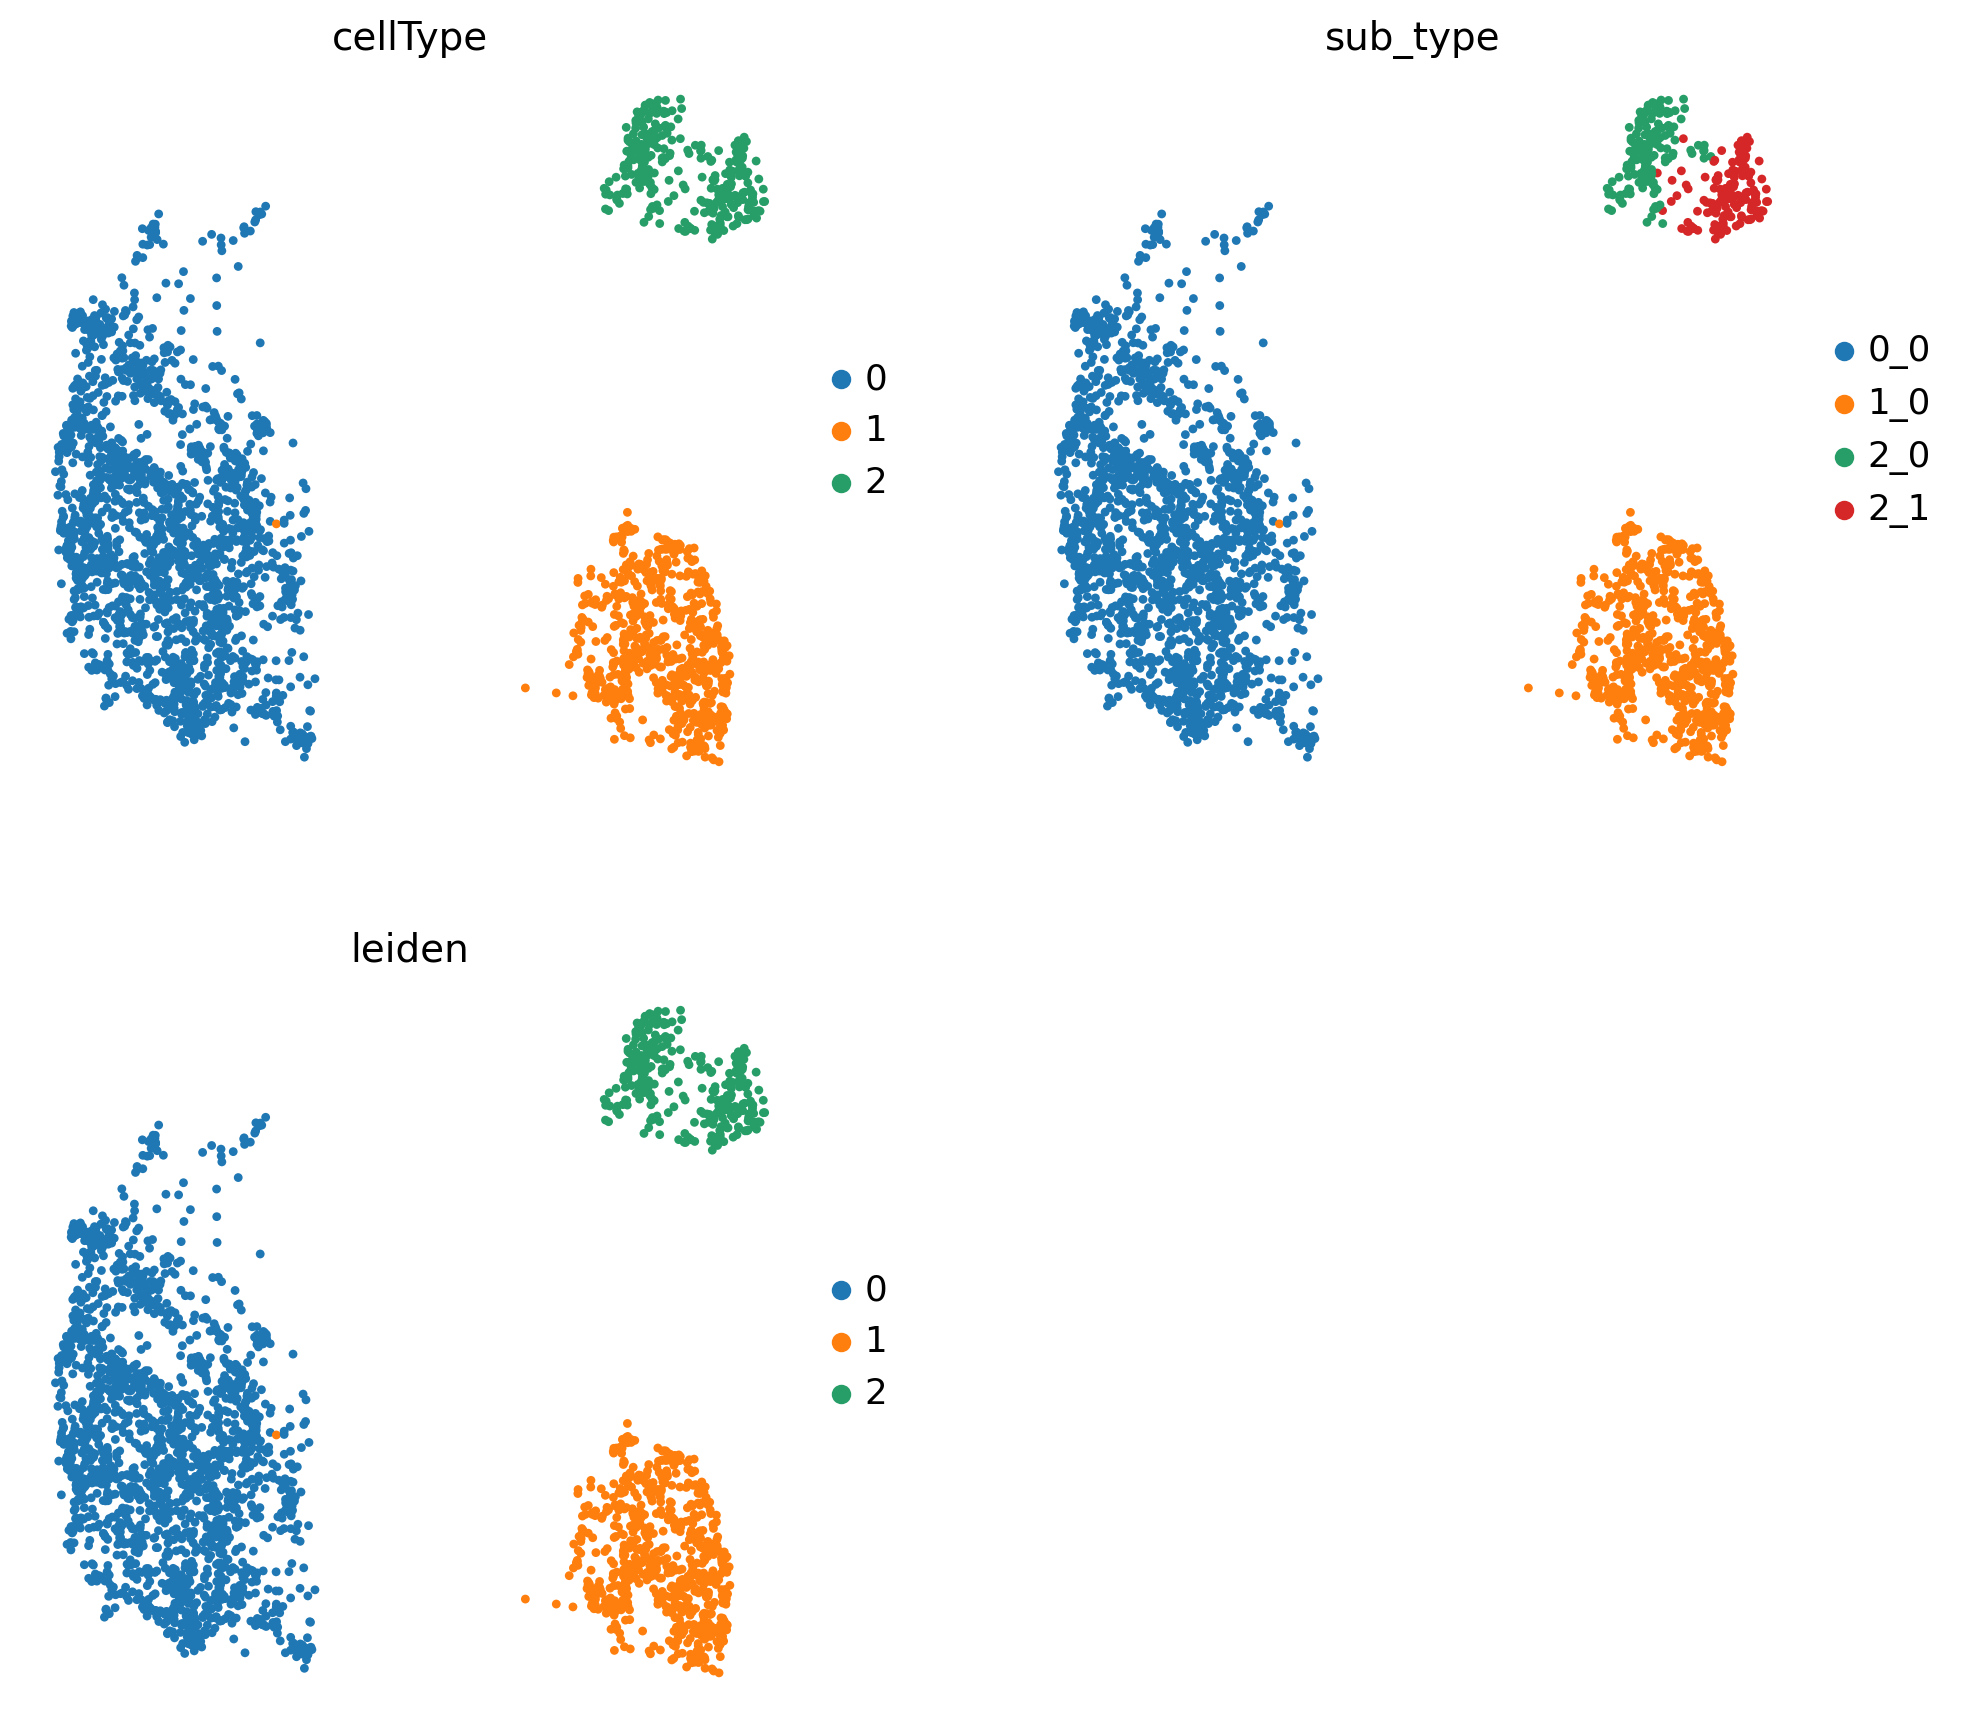

In [11]:
sc.external.tl.trimap(decon.sadata)
sc.external.pl.trimap(decon.sadata, color=["cellType", "sub_type", "leiden"], ncols=2, frameon=False)

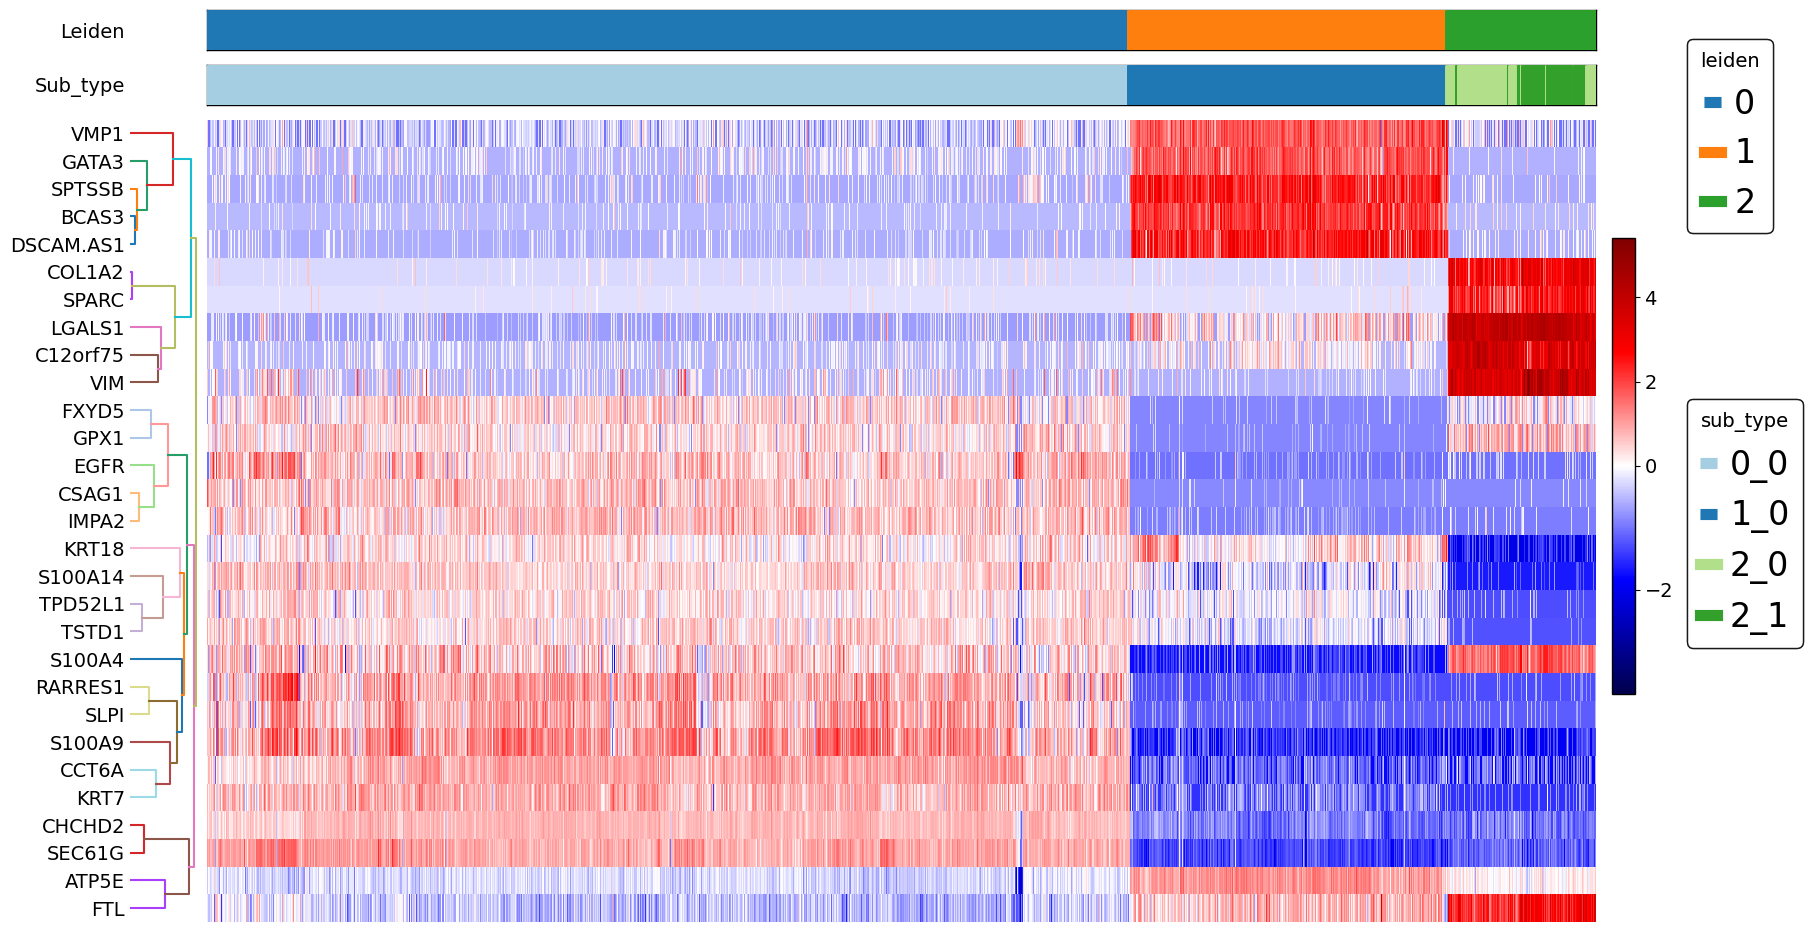

In [12]:
pl.heatmap(
    decon.sadata, groupby=decon.label_key, categorical_features=[decon.label_key, "sub_type"], free_sort_cells=False
)

Using 319 cells from 3 cellTypes


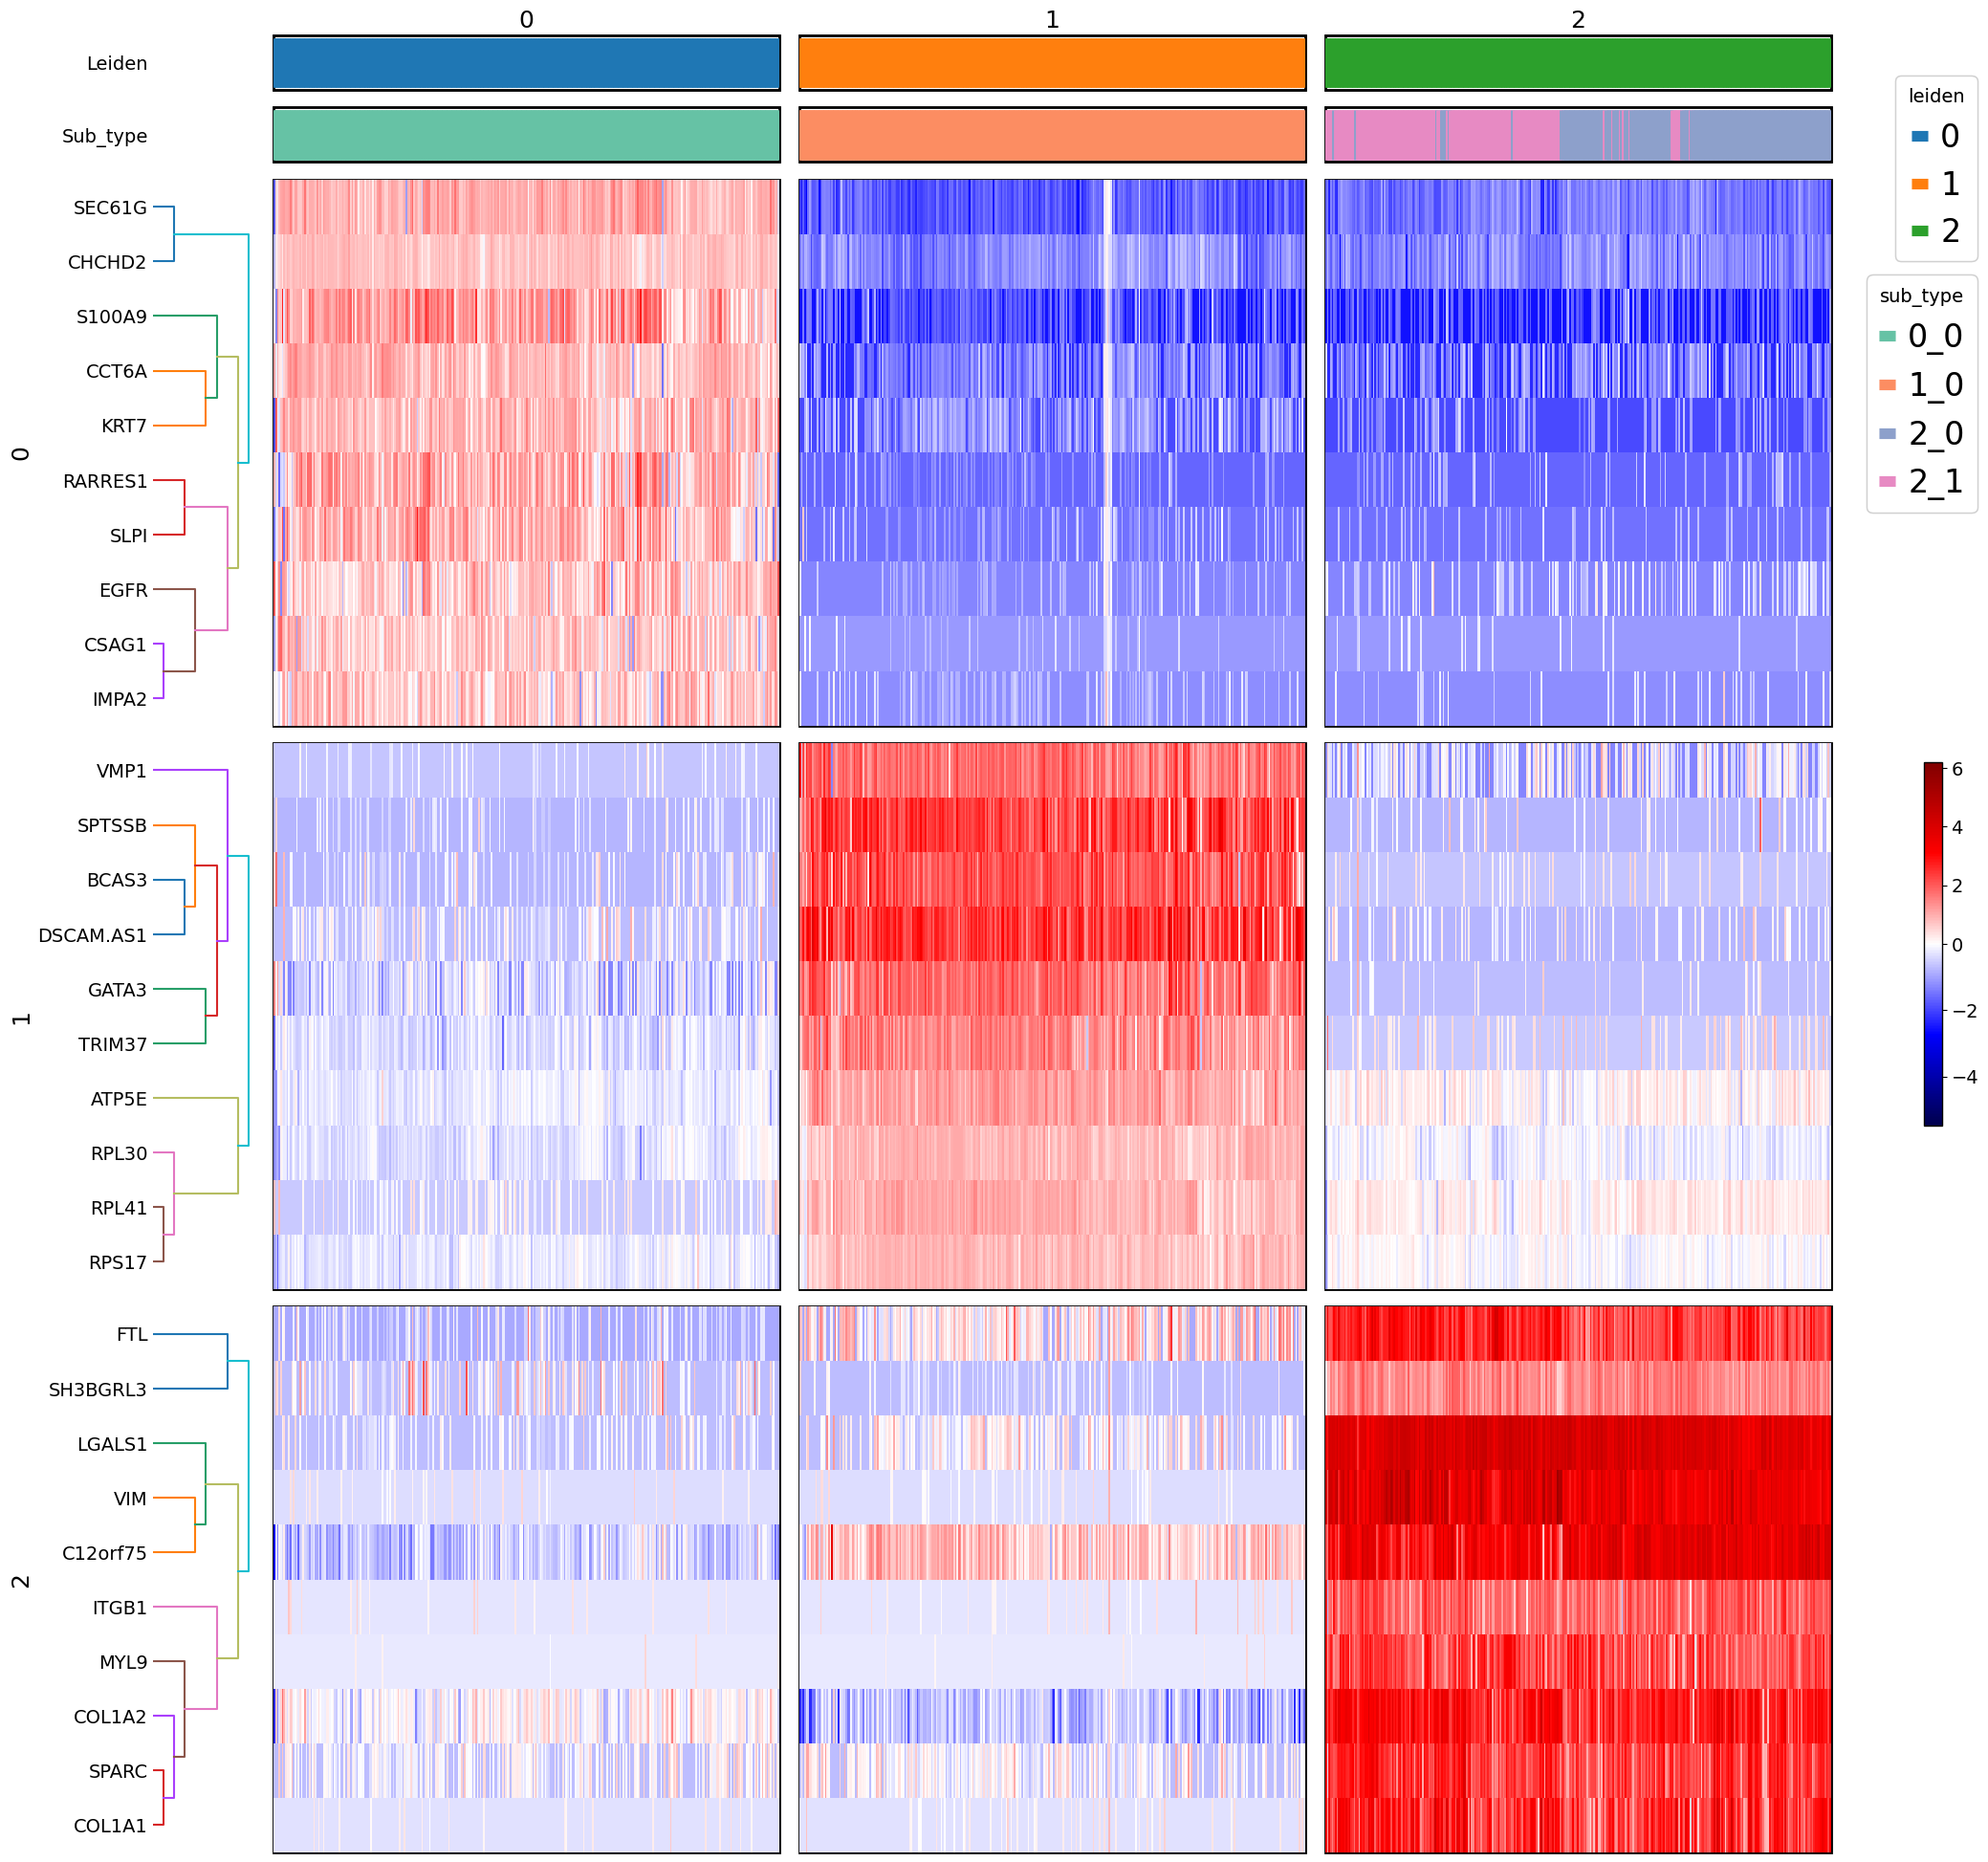

In [13]:
pl.clustermap(decon.sadata, clusterby="cellType", categorical_features=[decon.label_key, "sub_type"], min_cells=45)

In [14]:
# decon.filter_outliers(dropout_mu_lim=2.5, dropout_lim=1.0, marker_zscore_lim=0.3, dispersion_lims=(-3, 1), pseudobulk_lims=(-8,8))
decon.filter_outliers()

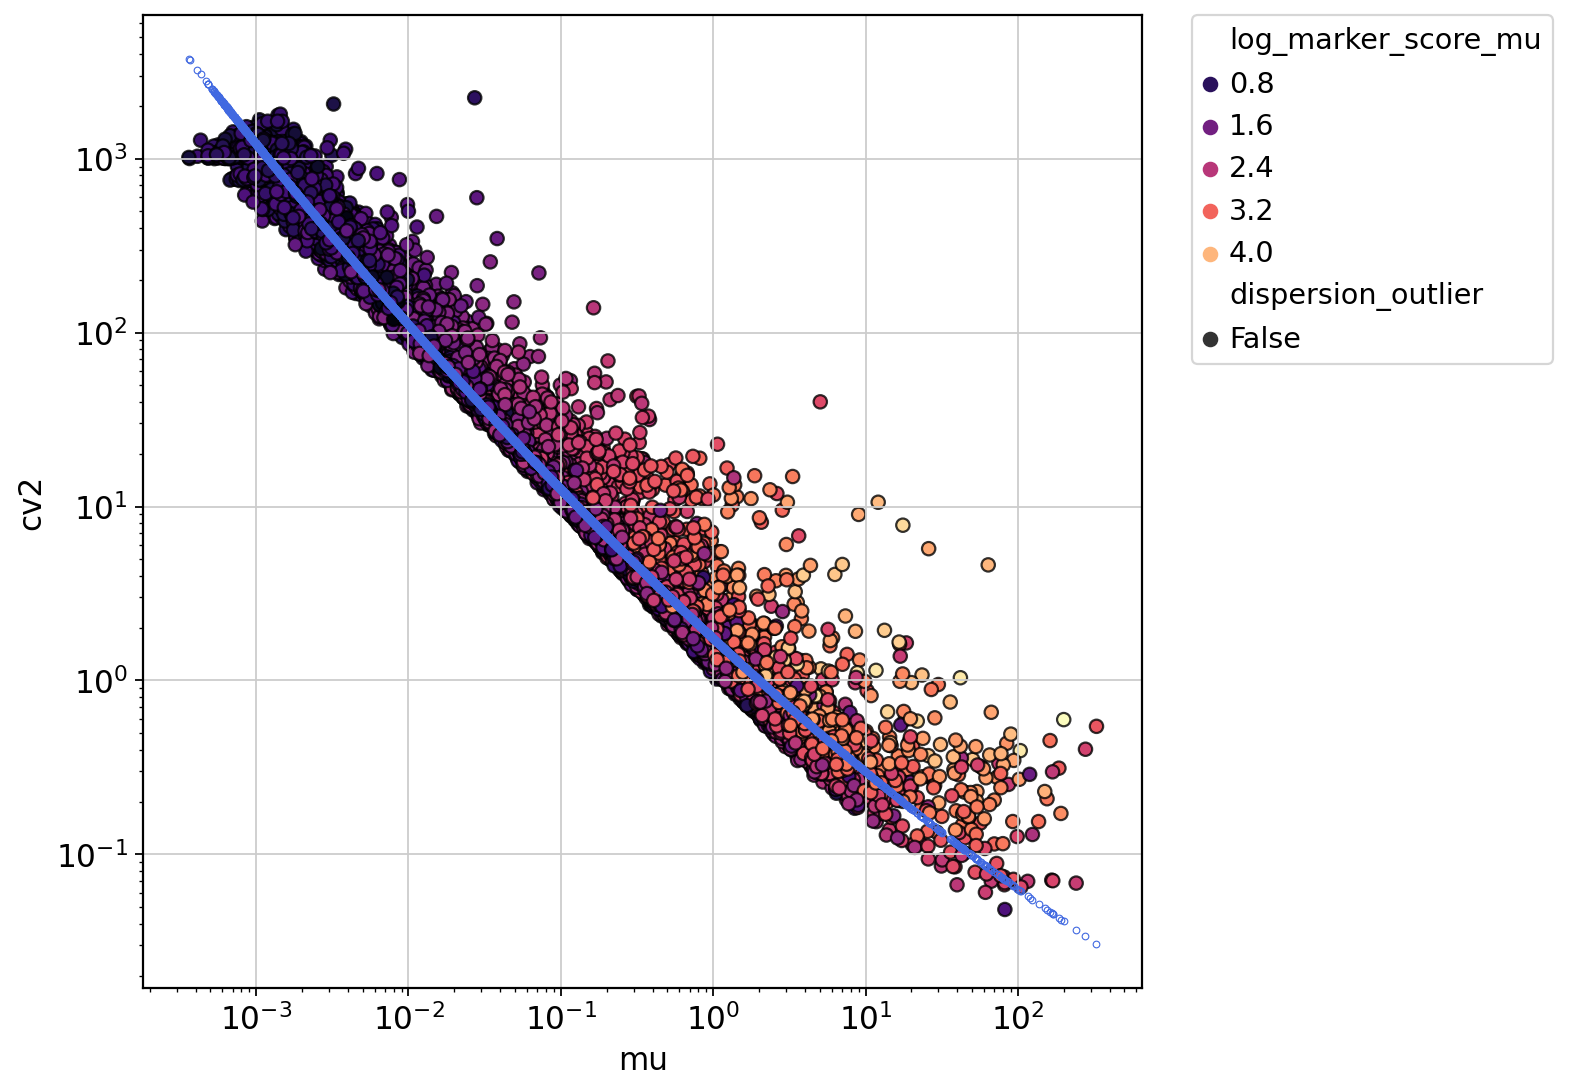

In [15]:
pl.dispersion_plot(decon, hue="log_marker_score_mu", style="dispersion_outlier", figsize=(8,8), dpi=80, separate_ct=False, palette="magma")

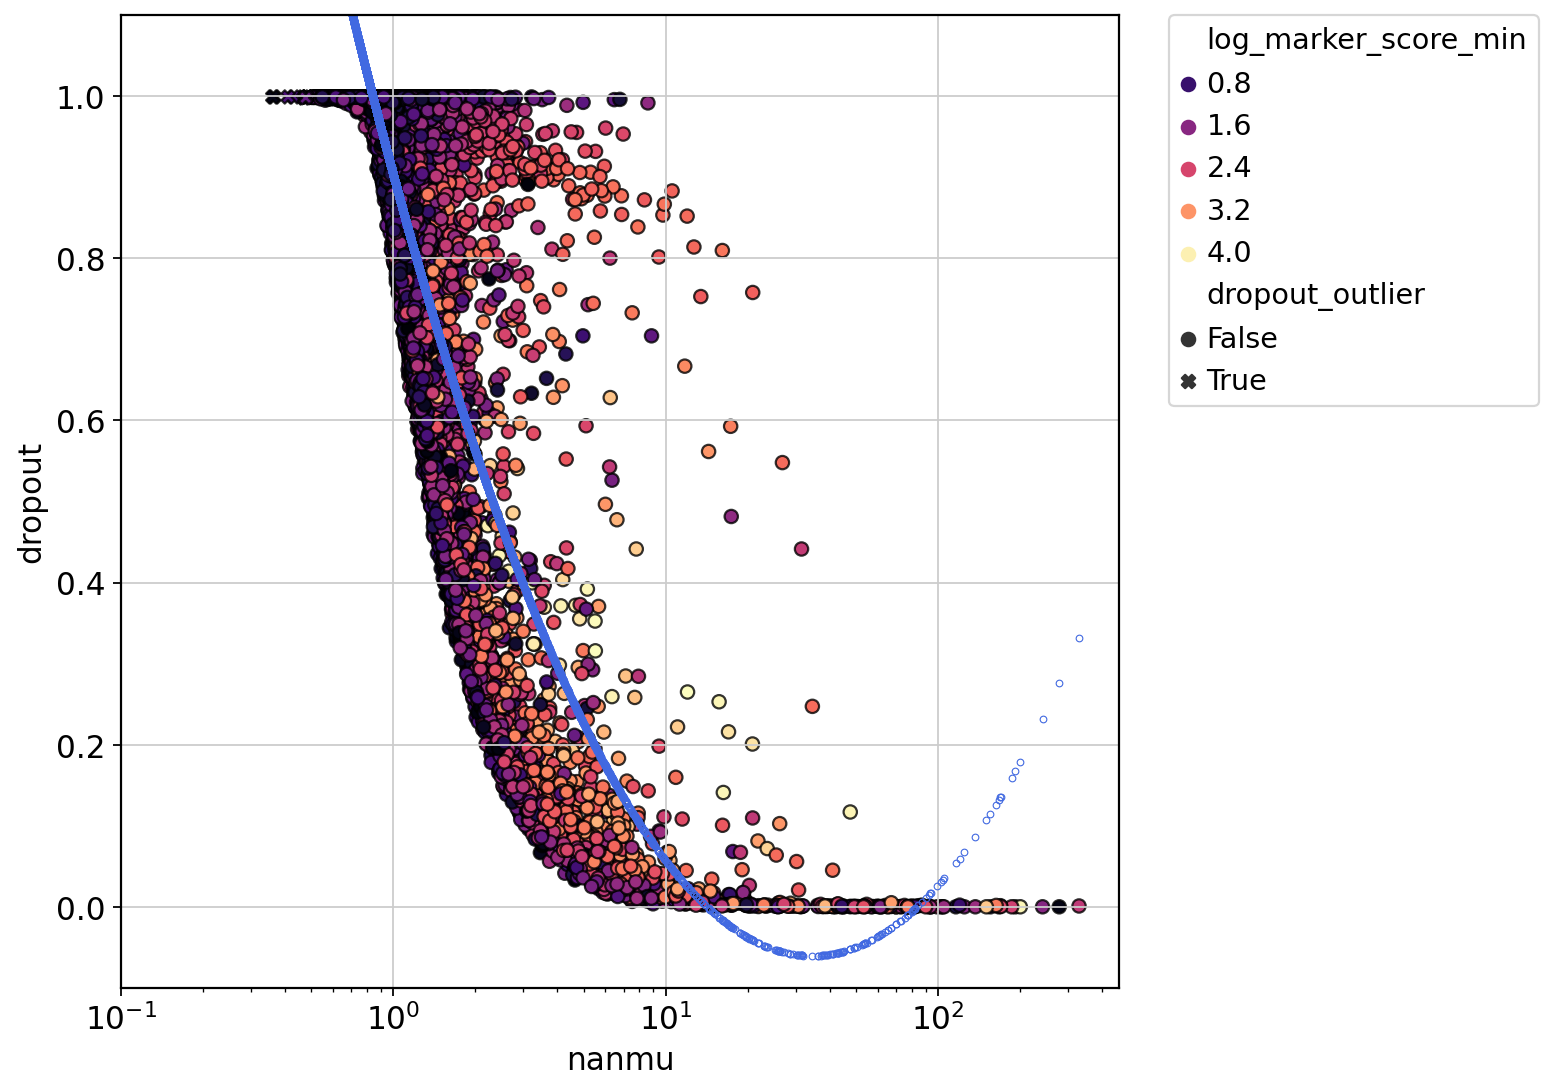

In [16]:
pl.dropout_plot(decon, hue="log_marker_score_min", style="dropout_outlier", xlim=(0.1, None), dpi=80, separate_ct=False, palette="magma")

In [17]:
# pl.pseudo_bulk_plot(
#     decon, hue="log_bulk_residual", style="pseudobulk_outlier", palette="magma"
# )

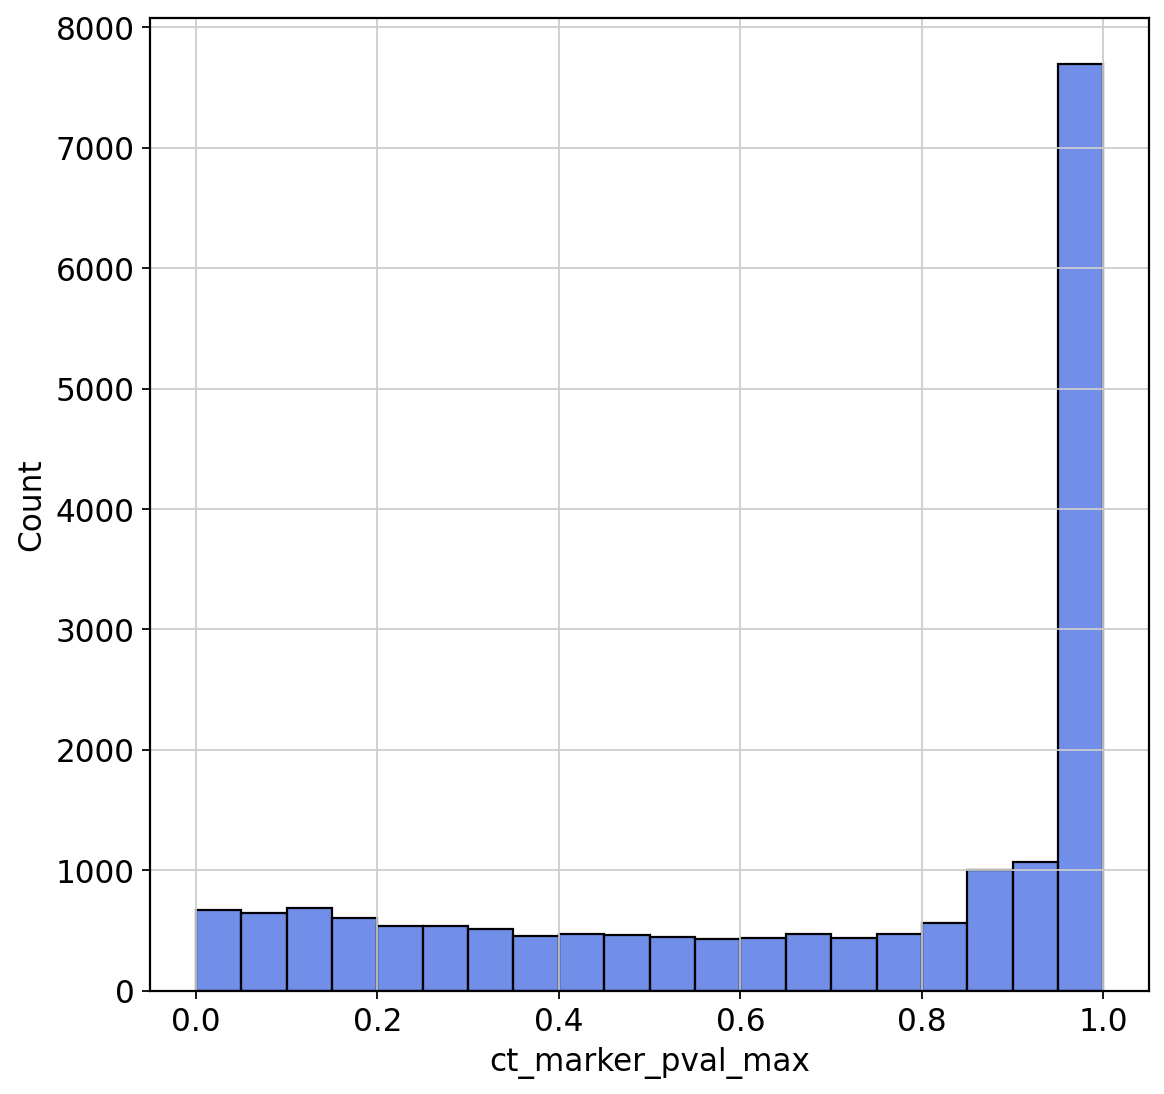

Creating signature for cell types: ['0', '2', '1']...


/home/lutrarutra/Documents/dev/fimm/deconv/core/deconV.py:274: RuntimeWarning: divide by zero encountered in true_divide
  self.normalising_constant = 1.0 / torch.tensor(np.nanmean(np.nan_to_num(self.sadata.layers["counts"].sum(0) / self.badata.layers["counts"], posinf=np.nan), axis=1))


In [18]:
decon.init_dataset(use_outliers=False, gene_weight_key="ct_marker_pval_max")
decon.init_signature()

Sample: 0/1


100%|██████████| 5000/5000 [00:04<00:00, 1037.43it/s, loss=288437.8, props=0.62 0.19 0.19, lib_size=1507578.2]


Plotting results...


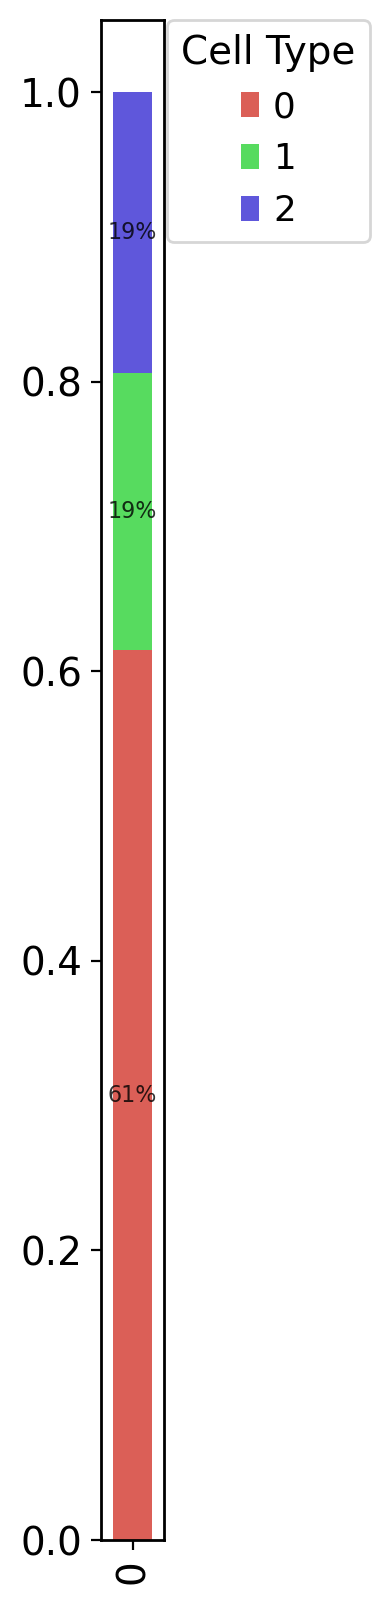

In [19]:
est_df = decon.deconvolute()

In [20]:
true_df = pd.read_csv("../../data/xin/true.tsv", "\t", index_col=0)

/home/lutrarutra/mambaforge/envs/lst/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


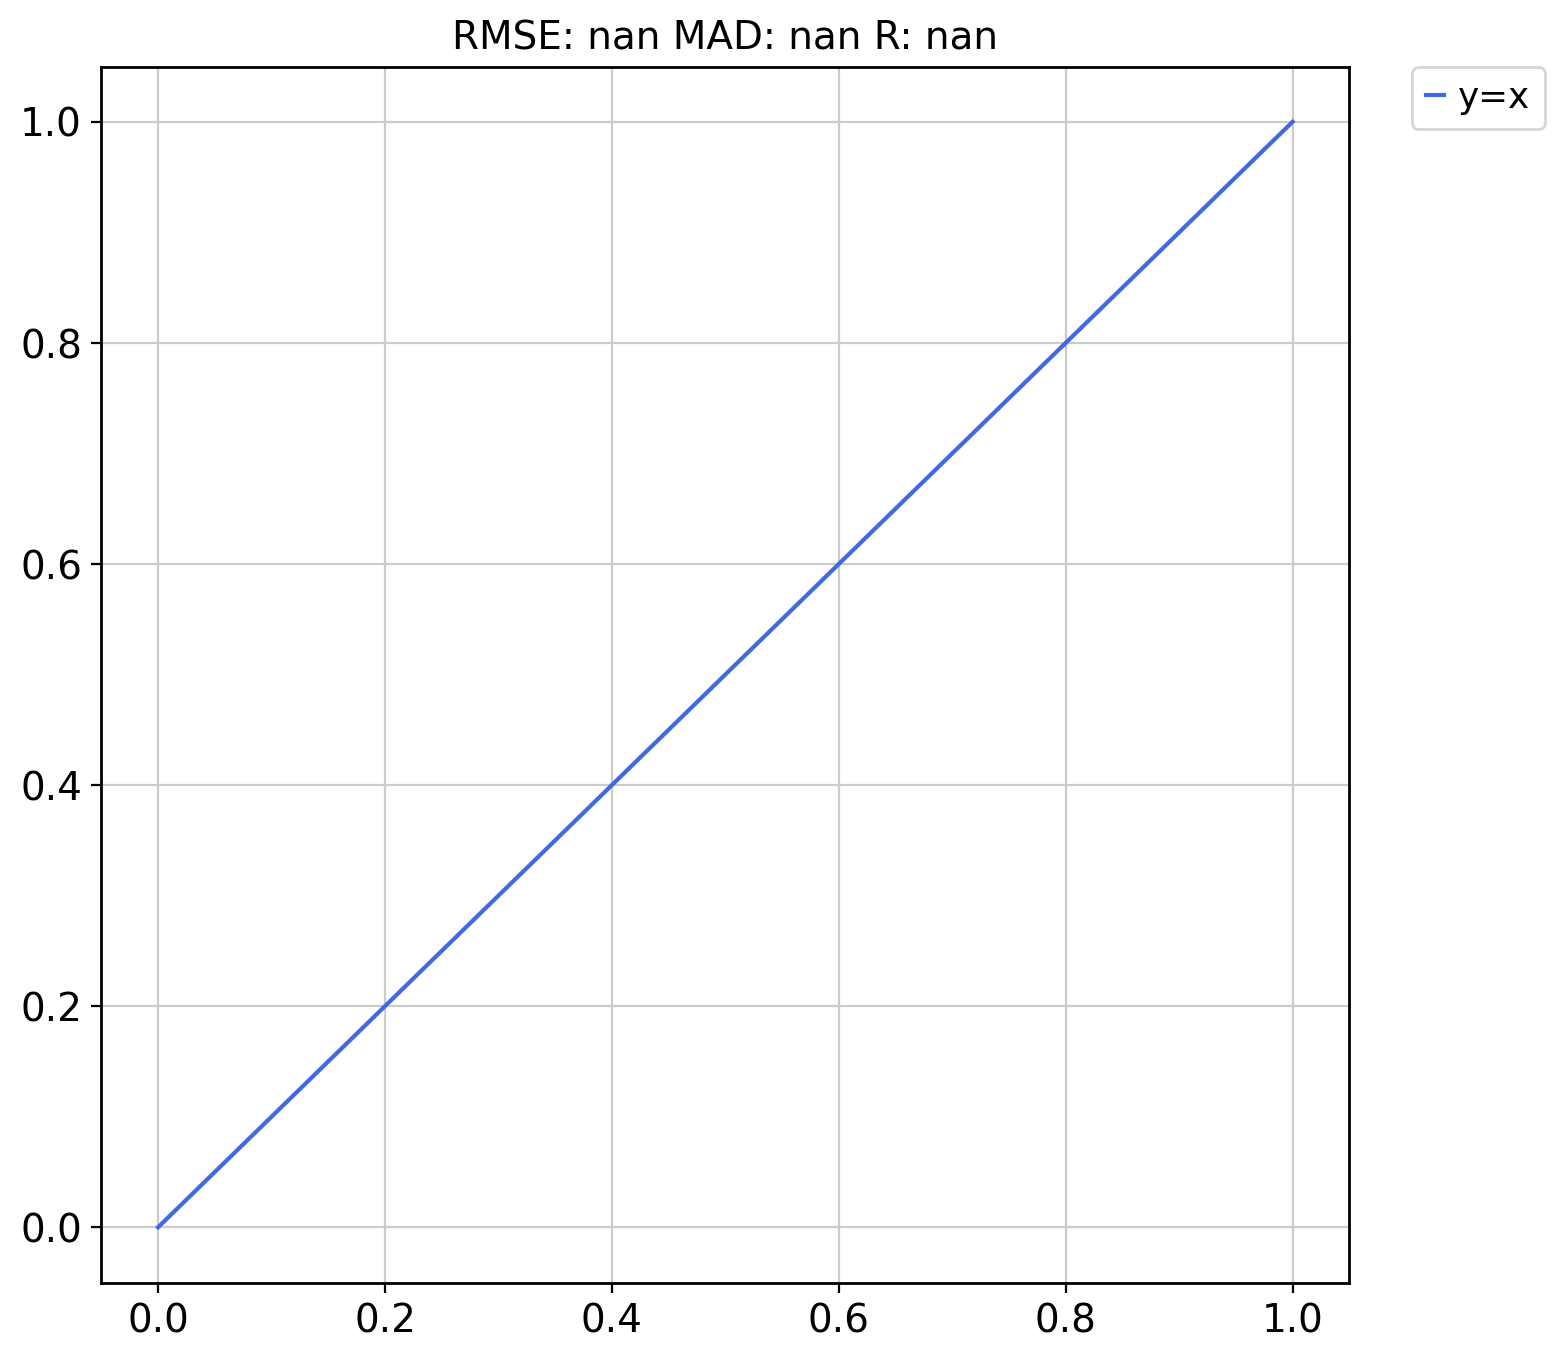

In [21]:
pl.scatter_check(true_df, est_df, style="sample")